___
<a href='https://cafe.naver.com/jmhonglab'><p style="text-align:center;"><img src='https://lh3.googleusercontent.com/lY3ySXooSmwsq5r-mRi7uiypbo0Vez6pmNoQxMFhl9fmZJkRHu5lO2vo7se_0YOzgmDyJif9fi4_z0o3ZFdwd8NVSWG6Ea80uWaf3pOHpR4GHGDV7kaFeuHR3yAjIJjDgfXMxsvw=w2400'  class="center" width="50%" height="50%"/></p></a>
___
<center><em>Content Copyright by HongLab, Inc.</em></center>

# 지도 학습(Supervised Learning) - 분류(Classification)

- CrossEntropyLoss
- Fully-connected layer (torch.nn.Linear())
- Relu activation function






### 분류 데이터셋

간단한 데이터셋은 [sklearn의 datasets](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.datasets) 사용

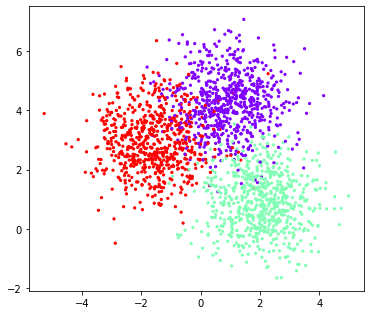

(2000, 2) float64
[[-1.64139106  3.16951251]
 [-2.29386705  4.09394254]
 [ 0.83269057  3.92176188]
 [ 2.60786751  4.6815465 ]
 [ 3.33872256  1.49561015]]
(2000,) int32
[2 2 0 0 1]


In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import datasets

samples, labels = datasets.make_blobs(n_samples=2000, centers=3, random_state=0)

plt.figure(figsize=(6, 6))
ax = plt.gca()
ax.set_aspect(1.0)
ax.scatter(samples[:, 0], samples[:, 1], c=labels, cmap="rainbow", s=5)
plt.show()

print(samples.shape, samples.dtype) # (2000, 2) float64
print(samples[0:5])
print(labels.shape, labels.dtype) # (2000,) int32
print(labels[0:5]) # [2 2 0 0 1 0 1 0 1 0]


### 훈련 방법

CrossEntropyLoss
- 모델의 출력 y_pred과 정답 y_target으로 Loss를 정의한다.
- 이때 y_target은 label(정수 한 개) 이다.

In [2]:
import torch

criterion = torch.nn.CrossEntropyLoss()  # 정보 이론에서 유도

y_target = torch.tensor([2], dtype=torch.long) # 샘플 하나일 경우
y_pred = torch.tensor([[1.1, 0.8, 2.2]], dtype=torch.float) # 네트워크 출력

loss = criterion(y_pred, y_target)

print(loss.item())

0.45708808302879333


argmax()

In [3]:
import numpy as np

# 3가지로 분류하는 모델에 샘플 2개를 넣었을 경우 가상의 예시
y_pred = np.array([[0.2, 0.8, 0.1], [0.9, 0.1, 0.5]]) # shape가 (2, 3)
np.array(y_pred).argmax(axis=1) # array([1, 0], dtype=int64)

# 비교: torch.tensor의 argmax에서는 dim 사용
y_pred = torch.tensor([[0.2, 0.8, 0.1], [0.9, 0.1, 0.5]]) # torch.Size([2, 3])
y_pred.argmax(dim=1) # tensor([1, 0]) torch.tensor에서는 dim 사용

tensor([1, 0])

훈련 코드

In [4]:
import torch


def train(x, y, model, criterion, optimizer, num_epochs):

    # 전체 샘플을 train과 test로 나눠서 test는 훈련에 사용하지 않는다.
    # test는 model이 일반화가 잘 되었는지 확인하는 용도로 사용
    i_split = x.shape[0] // 10 # 전체의 10%는 test용으로 따로 분류
    x_train, x_test = x[i_split:], x[:i_split]
    y_train, y_test = y[i_split:], y[:i_split]

    loss_history = []
    train_accuracy_history = [] # 평가 기준에 정확도 추가
    test_accuracy_history = [] # 평가 기준에 정확도 추가

    for epoch in range(1, num_epochs + 1):
        optimizer.zero_grad()
        y_pre = model(x_train)
        loss = criterion(y_pre, y_train)
        loss.backward()
        optimizer.step()

        loss_history.append(loss.item())

        # train과 test 따로 분류 정확도 확인
        train_accuracy = model(x_train).argmax(dim=1).eq(y_train).sum().item() / y_train.shape[0] * 100.0
        train_accuracy_history.append(train_accuracy)

        test_accuracy = model(x_test).argmax(dim=1).eq(y_test).sum().item() / y_test.shape[0] * 100.0
        test_accuracy_history.append(test_accuracy)

        if epoch % (num_epochs // 5) == 0:
            print(f"Epoch {epoch}: loss = {loss.item()}, accuracy = [{train_accuracy:.2f}, {test_accuracy:.2f}]")

    return loss_history, train_accuracy_history, test_accuracy_history



def visualize(model, samples, labels, loss_history, train_accuracy_history, test_accuracy_history):    

    plt.figure(figsize=(18, 6))

    ax131 = plt.subplot(131)
    ax131.set_aspect(1.0)
    ax131.scatter(samples[:, 0], samples[:, 1], c = labels, cmap="rainbow", s = 5)
    xl = ax131.get_xlim()
    yl = ax131.get_ylim()

    ax132 = plt.subplot(132)
    ax132.set_aspect(1.0)
    labels_pre = model(torch.tensor(samples, dtype=torch.float)).argmax(dim=1).detach().numpy()
    # 모델이 추측한 labels를 이용해서 샘플들의 색을 칠해준다.
    ax132.scatter(samples[:, 0], samples[:, 1], c = labels_pre, cmap="rainbow", s = 5)
    ax132.set_xlim(xl)
    ax132.set_ylim(yl)

    x_range = np.arange(xl[0], xl[1], 0.01)
    y_range = np.arange(yl[0], yl[1], 0.01)
    X, Y = np.meshgrid(x_range, y_range)
    xy = np.stack([X.flatten(), Y.flatten()], axis=1)
    Z = (
        model(torch.tensor(xy, dtype=torch.float))
        .argmax(dim=1)
        .detach()
        .numpy()
        .reshape(X.shape)
    )

    ax132.pcolormesh(X, Y, Z, cmap="rainbow", alpha = 0.2)

    ax1 = plt.subplot(133)
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.plot(loss_history, c = "r")
    ax2 = ax1.twinx()
    ax2.set_ylabel("Train accuracy (%)")
    ax2.plot(train_accuracy_history, c = "g")
    ax2.plot(test_accuracy_history, c = "b")



##### 뉴럴 네트워크의 완전 연결 층 (Fully-Connected Layer)

모델 정의
- 입력과 출력의 개수를 잘 맞춰줘야 한다. 
- 예를 2차원 xy 평면상의 점들 2000를 3가지로 분류를 한다면 입력의 shape는 (2000, 2), 출력의 shape는 (2000, 3)이 되어야 한다.

[torch.nn.Linear(in_features, out_features)](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)  

모든 입력과 모든 출력이 연결되어 있음  
Linear(1, 1)은 앞에서 사용한 선형 모델과 동일

예시) $x_1$, $x_2$ -> Linear(2, 3) -> $y_1$, $y_2$, $y_3$  

$y_1 = w_{11} \cdot x_1 + w_{12} \cdot x_2 + b_1$  
$y_2 = w_{21} \cdot x_1 + w_{22} \cdot x_2 + b_2$  
$y_3 = w_{31} \cdot x_1 + w_{32} \cdot x_2 + b_3$

[참고] [tf.keras.layers.Dense()](https://keras.io/api/layers/core_layers/dense/)

In [31]:
import torch

class MyModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = torch.nn.Linear(2, 3)

    def forward(self, x): 
        x = self.l1(x)
        return x

model = MyModel()

# 간단한 구조는 nn.Sequential 사용
model = torch.nn.Sequential(
    torch.nn.Linear(2, 3),
)

print(list(model.parameters()))

x_input = torch.randn((1000, 2))

y_pre = model(x_input)

print(y_pre.shape) # torch.Size([1000, 3])

[Parameter containing:
tensor([[ 0.6181,  0.3022],
        [-0.1589,  0.5098],
        [-0.2290, -0.2013]], requires_grad=True), Parameter containing:
tensor([-0.5290,  0.1934, -0.1916], requires_grad=True)]
torch.Size([1000, 3])


Epoch 8: loss = 0.5761820077896118, accuracy = [79.83, 79.00]
Epoch 16: loss = 0.31910112500190735, accuracy = [90.00, 91.00]
Epoch 24: loss = 0.2654034495353699, accuracy = [91.06, 93.00]
Epoch 32: loss = 0.23801828920841217, accuracy = [91.44, 94.00]
Epoch 40: loss = 0.22786249220371246, accuracy = [91.89, 94.00]


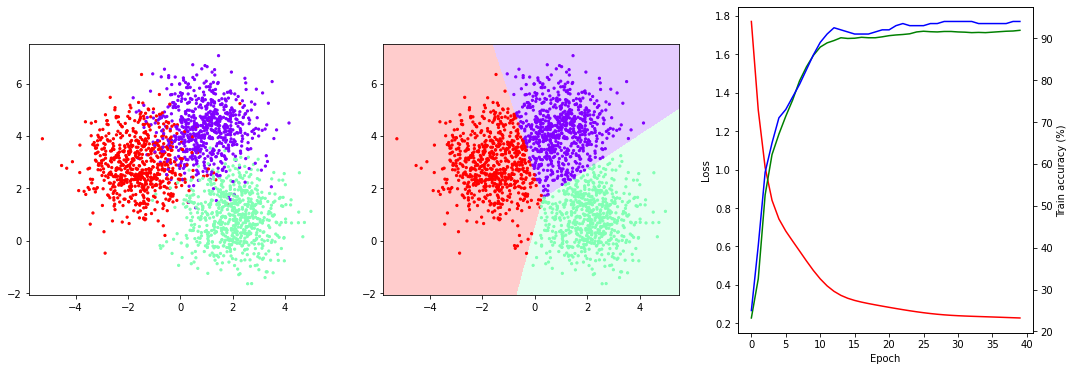

In [6]:
class MyModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = torch.nn.Linear(2, 3)

    def forward(self, x): 
        x = self.l1(x) # (N, 2) -> (N, 3), 여기서 N은 샘플 개수이며 N은 바뀔 수 있다.
        return x


model = MyModel()

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)

samples, labels = datasets.make_blobs(n_samples=2000, centers=3, random_state=0)

x = torch.tensor(samples, dtype=torch.float)
y = torch.tensor(labels, dtype=torch.long) # long은 64비트를 사용하는 정수형

loss_history, train_acc_history, test_acc_history = train(x, y, model, criterion, optimizer, num_epochs=40)

visualize(model, samples, labels, loss_history, train_acc_history, test_acc_history) # train이 green, test가 blue

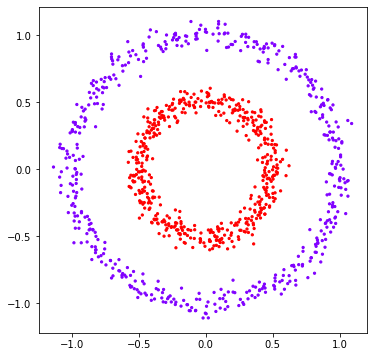

In [33]:
import matplotlib.pyplot as plt
from sklearn import datasets

samples, labels = datasets.make_circles(n_samples=1000, factor=0.5, noise=0.05)

plt.figure(figsize=(6, 6))
ax = plt.gca()
ax.set_aspect(1.0)
ax.scatter(samples[:, 0], samples[:, 1], c=labels, cmap="rainbow", s=5)

Epoch 8: loss = 1054.5186767578125, accuracy = [47.44, 46.50]
Epoch 16: loss = 3223.05224609375, accuracy = [58.50, 56.00]
Epoch 24: loss = 909.164306640625, accuracy = [49.67, 53.00]
Epoch 32: loss = 1038.809814453125, accuracy = [63.00, 65.00]
Epoch 40: loss = 200.21115112304688, accuracy = [49.67, 53.00]


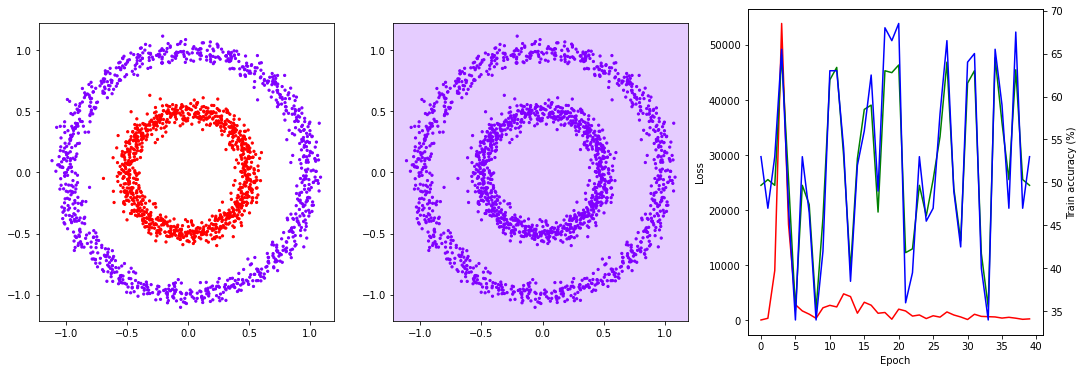

In [36]:
# nn.Sequential 사용
model = torch.nn.Sequential(
    torch.nn.Linear(2, 512),
    torch.nn.Linear(512, 512),
    torch.nn.Linear(512, 512),
    torch.nn.Linear(512, 2),
)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)

samples, labels = datasets.make_circles(n_samples=2000, factor=0.5, noise=0.05)

x = torch.tensor(samples, dtype=torch.float)
y = torch.tensor(labels, dtype=torch.long)

loss_history, train_acc_history, test_acc_history = train(x, y, model, criterion, optimizer, num_epochs=40)

visualize(model, samples, labels, loss_history, train_acc_history, test_acc_history)

##### ReLU()
- 비선형 활성화 함수(activation function)
- [더 많은 활성화 함수들](https://en.wikipedia.org/wiki/Activation_function)

Epoch 20: loss = 0.15872211754322052, accuracy = [99.89, 100.00]
Epoch 40: loss = 0.010644498281180859, accuracy = [100.00, 100.00]
Epoch 60: loss = 0.003998905885964632, accuracy = [100.00, 100.00]
Epoch 80: loss = 0.00269970647059381, accuracy = [100.00, 100.00]
Epoch 100: loss = 0.0021609135437756777, accuracy = [100.00, 100.00]


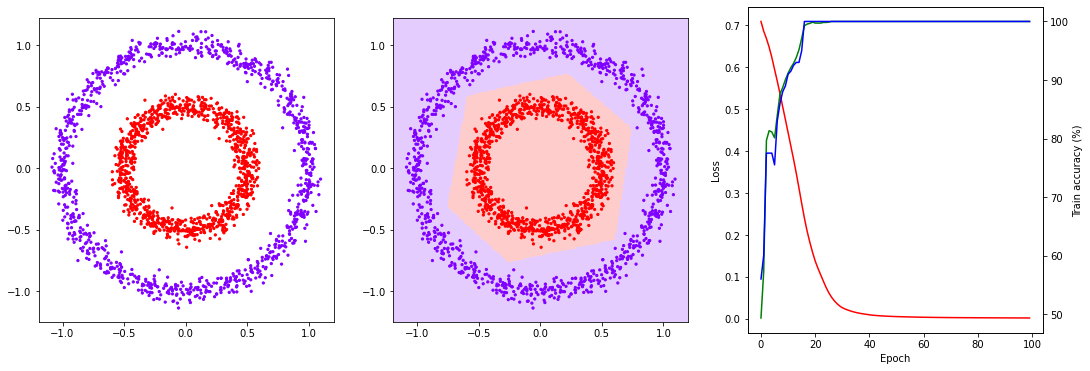

In [37]:
# nn.Sequential 사용
model = torch.nn.Sequential(
    torch.nn.Linear(2, 8),
    torch.nn.ReLU(),
    torch.nn.Linear(8, 2),
)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)

samples, labels = datasets.make_circles(n_samples=2000, factor=0.5, noise=0.05)

x = torch.tensor(samples, dtype=torch.float)
y = torch.tensor(labels, dtype=torch.long)

loss_history, train_acc_history, test_acc_history = train(x, y, model, criterion, optimizer, num_epochs=100)

visualize(model, samples, labels, loss_history, train_acc_history, test_acc_history)

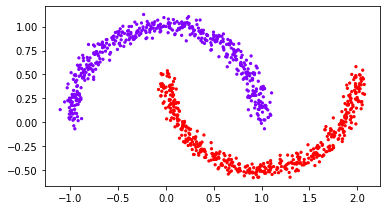

In [23]:
import matplotlib.pyplot as plot
from sklearn import cluster, datasets

samples, labels = datasets.make_moons(n_samples=1000, noise=0.05)

plt.figure(figsize=(6, 6))
ax = plt.gca()
ax.set_aspect(1.0)
ax.scatter(samples[:, 0], samples[:, 1], c=labels, cmap="rainbow", s=5)

Epoch 8: loss = 0.1867939978837967, accuracy = [91.61, 95.00]
Epoch 16: loss = 0.04979429021477699, accuracy = [99.56, 100.00]
Epoch 24: loss = 0.0021507602650672197, accuracy = [100.00, 100.00]
Epoch 32: loss = 0.00020398260676302016, accuracy = [100.00, 100.00]
Epoch 40: loss = 3.944625859730877e-05, accuracy = [100.00, 100.00]


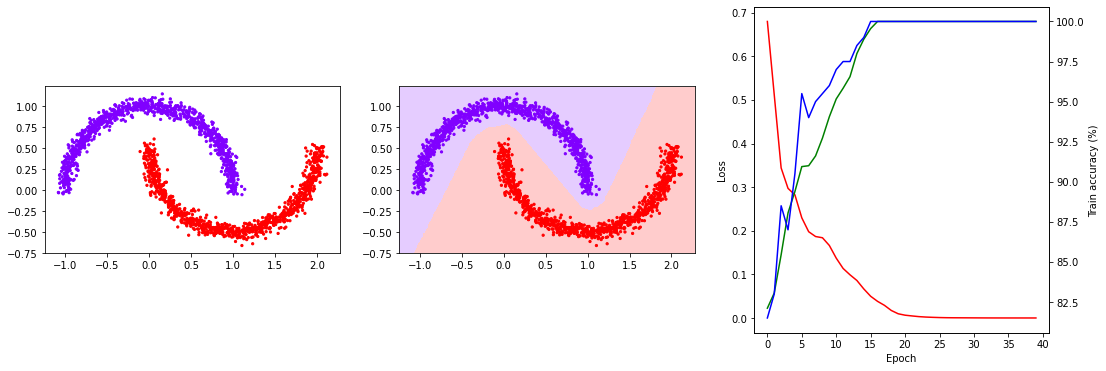

##### [실습] Spiral 데이터셋

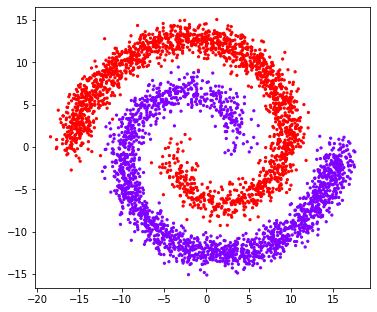

In [12]:
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt

# https://gist.github.com/45deg/e731d9e7f478de134def5668324c44c5
def get_spiral(num_samples):
    theta = np.sqrt(np.random.rand(num_samples)) * 2 * pi  # np.linspace(0,2*pi,100)

    r_a = 2 * theta + pi
    data_a = np.array([np.cos(theta) * r_a, np.sin(theta) * r_a]).T
    x_a = data_a + np.random.randn(num_samples, 2)

    r_b = -2 * theta - pi
    data_b = np.array([np.cos(theta) * r_b, np.sin(theta) * r_b]).T
    x_b = data_b + np.random.randn(num_samples, 2)

    res_a = np.append(x_a, np.zeros((num_samples, 1)), axis=1)
    res_b = np.append(x_b, np.ones((num_samples, 1)), axis=1)

    res = np.append(res_a, res_b, axis=0)
    np.random.shuffle(res)

    y_a = np.empty(x_a.shape[0])
    y_a.fill(0)
    y_b = np.empty(x_b.shape[0])
    y_b.fill(1)

    x = np.concatenate([x_a, x_b])
    y = np.concatenate([y_a, y_b])

    p = np.random.permutation(len(x))

    return x[p], y[p]

import matplotlib.pyplot as plot
from sklearn import cluster, datasets

samples, labels = get_spiral(2000)

plt.figure(figsize=(6, 6))
ax = plt.gca()
ax.set_aspect(1.0)
ax.scatter(samples[:, 0], samples[:, 1], c=labels, cmap="rainbow", s=5)

Epoch 20: loss = 0.29275938868522644, accuracy = [89.44, 91.50]
Epoch 40: loss = 0.026657437905669212, accuracy = [99.53, 99.50]
Epoch 60: loss = 0.013194970786571503, accuracy = [99.75, 99.75]
Epoch 80: loss = 0.011172031052410603, accuracy = [99.81, 99.75]
Epoch 100: loss = 0.010625655762851238, accuracy = [99.81, 99.75]


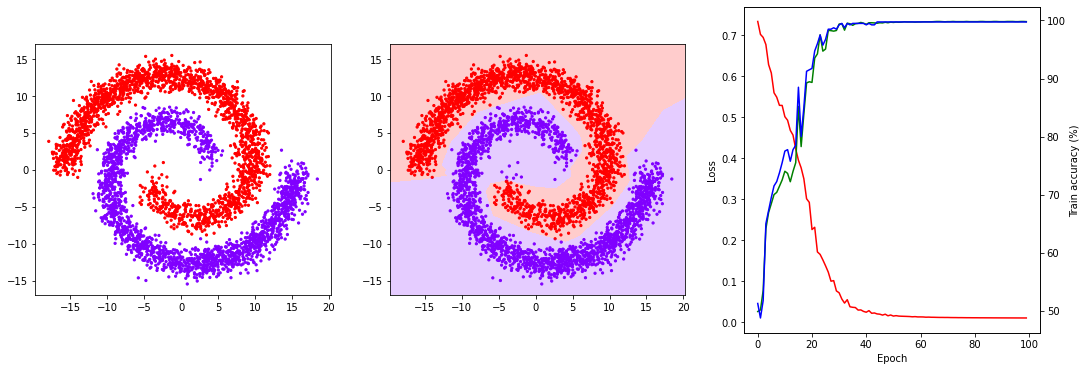

In [25]:
import torch

torch.manual_seed(0)



##### 더 해보고 싶다면
[A Neural Network Playground - Tensorflow](https://playground.tensorflow.org)
